In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functions as ephys
from braingeneers import analysis
import shutil
import os
os.chdir('/media/kang/Seagate_External/PycharmProjects/ephys_pipeline/kilosort2_simplified/src')
import sys
sys.path.append("../src")
from plots import PlotlyEphys
# matplotlib font setting for illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
base_path = "/media/kang/Seagate_External/PycharmProjects/seizure_propagation/"
data_path = base_path + "data/Hc112723_hckcr1_21841_120323_base_cleaned.zip"
figure_name = "Hc112723_hckcr1_21841_120323_base"
burst_range = [(9, 12),  # (0, 30) peak at a little past 10
               (210, 213)]  # peak at a little past 210

In [3]:
train, neuron_data, config, fs = ephys.load_curation(data_path)
sd = analysis.SpikeData(train, neuron_data={0: neuron_data})
spike_data = {"train": [t*fs for t in train], 
              "neuron_data": neuron_data, 
              "fs": fs, 
              "config": config}
pe = PlotlyEphys(spike_data, title=figure_name)   # plotting is pretty slow, just use this function to get the data

Recording length: 313.14885
spare train shape (249, 313149)


In [4]:
# check burst width, there seems to be a problem with the burst width calculation
# the 90% drop from the peak shows a lower line on the plot 
# self.duration, self.peak_widths = pb.burst_width()

10.718 4585.102680925509
211.036 4305.366716177609


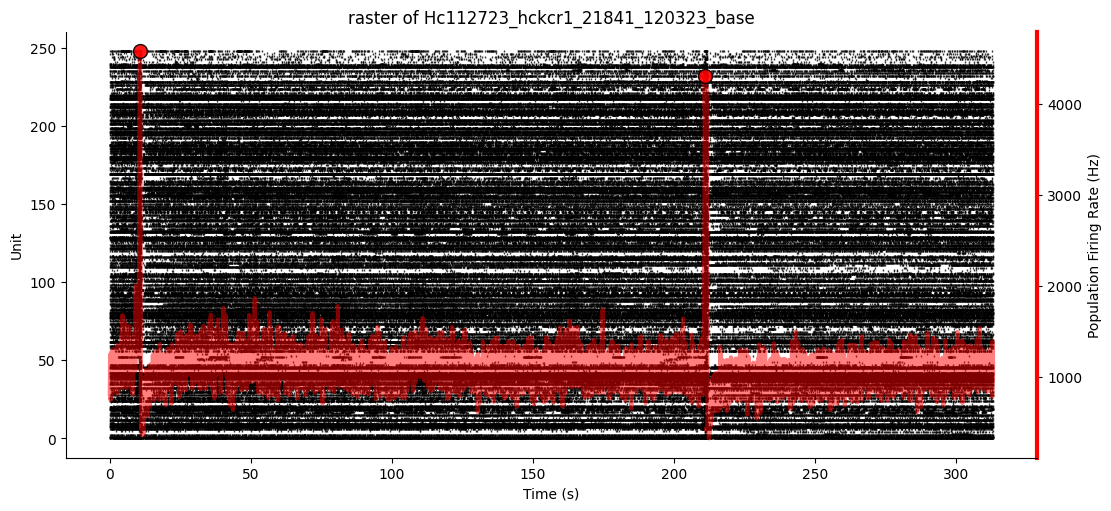

In [5]:
# plot raster with burst peak
fig, ax = plt.subplots(1, 1, figsize=(11, 5), constrained_layout=True)
y = 0
for vv in pe.train:
    ax.plot(vv, [y] * len(vv), '|', color='black', markersize=1, alpha=0.8)
    y += 1

# remove all spines and all ticks
ax.set_title(f"raster of {pe.title}")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Unit")

# make the rest of the axis linewidth=3
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
# plot fiing rate trace
ax2 = ax.twinx()
ax2.plot(pe.bins, pe.fr, color='red', linewidth=3, alpha=0.5)
# plot the peak timepoint of burst on top of the figure
for ind in pe.peak_indices:
    t = pe.bins[ind]
    pfr = pe.fr[ind]
    print(t, pfr)
    ax2.plot(t, pfr, 'o', color='red', markersize=10, alpha=0.9 , markeredgecolor='k')
    # plot the 10% burst peak line
    ax2.plot([t-0.5, t+0.5], [0.1*pfr, 0.1*pfr], '--', color='red', linewidth=3, alpha=0.5)
ax2.set_ylabel("Population Firing Rate (Hz)")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_linewidth(3)
# set ax2 color to red
ax2.spines['right'].set_color('red')

# for i in [0, 1]: 
#     ax2.set_xlim(burst_range[i])
#     plt.savefig(f"{base_path}figures/{figure_name}_raster_burst{i}_detection.png")

In [6]:
# for now, manually select the burst range
from collections import namedtuple
transp = False
propa_duration = 1.5 # seconds
bin_num = 15    # 12
propa_bin = propa_duration / bin_num      # sweep the bin from 50 ms to 125 ms to find the sweet spot
propa_bin_ms = int(propa_bin*1000)
print(propa_bin_ms)
sd_burst = {k: {"SpikeData": None, 
                "binarized_train": None,
                "base_fr":[]} for k in range(len(burst_range))}

std_threshold = 3

# i = 0
for i in range(len(burst_range)):
    ind = pe.peak_indices[i]
    t = pe.bins[ind]
    if i == 0:
        ts = t - propa_bin*(bin_num/2)
        te = t + propa_bin*(bin_num/2)
        print(ts, te)
    else:
        ts = t - propa_bin*4
        te = t + propa_bin*8

100
9.968 11.468


In [91]:
# for now, manually select the burst range
from collections import namedtuple
transp = False
propa_duration = 1.5 # seconds
bin_num = 15    # 12
propa_bin = propa_duration / bin_num      # sweep the bin from 50 ms to 125 ms to find the sweet spot
propa_bin_ms = int(propa_bin*1000)
print(propa_bin_ms)
sd_burst = {k: {"SpikeData": None, 
                "binarized_train": None,
                "base_fr":[]} for k in range(len(burst_range))}

std_threshold = 3

# i = 0
for i in range(len(burst_range)):
    ind = pe.peak_indices[i]
    t = pe.bins[ind]
    if i == 0:
        ts = t - propa_bin*(bin_num/2)
        te = t + propa_bin*(bin_num/2)
        print(ts, te)
    else:
        ts = t - propa_bin*4
        te = t + propa_bin*8

    base_fr_tuple = namedtuple("base", ['mu', 'sigma'])
    base_fr_lim = 5   # seconds for base firing rate calculation

    new_sd = sd.subtime(ts, te)
    sd_burst[i]["SpikeData"] = new_sd
    sd_burst[i]["binarized_train"] = new_sd.raster(bin_size=propa_bin)
    base_sd = sd.subtime(0, base_fr_lim)
    rasterized = base_sd.raster(bin_size=propa_bin)   # use the same bin for baseline and burst
    # get mean and std for each row of the rasterized data
    mu = np.mean(rasterized, axis=1)
    sigma = np.std(rasterized, axis=1)
    sd_burst[i]["base_fr"] = [base_fr_tuple(mu=mu, sigma=sigma) for mu, sigma in zip(mu, sigma)]

    # create the folder for the figures if not exist
    if not os.path.exists(f"{base_path}figures/binsize{propa_bin_ms}/burst{i}"):
        os.makedirs(f"{base_path}figures/binsize{propa_bin_ms}/burst{i}")

    # find the max std away from the mean
    std_away = []
    for c in range(sd_burst[i]["binarized_train"].shape[1]):
        col = sd_burst[i]["binarized_train"][:, c]
        for j in range(len(col)):
            mu, sigma = sd_burst[i]["base_fr"][j]
            std_away.append((col[j] - mu) / sigma)
    # print(std_away)
    std_away = np.array(std_away)
    std_away_1 = std_away[std_away != np.inf]
    std_away_2 = std_away_1[~np.isnan(std_away_1)]
    # print(std_away_2)
    max_std = np.max(std_away_2)
    print("max std for colormap", max_std)

    # plot the raster and the bin location and the sorted neurons
    for c in range(sd_burst[i]["binarized_train"].shape[1]):
        fig, axs_map = plt.subplots(figsize=(11, 6), constrained_layout=True, tight_layout=True) 
        std_away = []
        col = sd_burst[i]["binarized_train"][:, c]
        for j in range(len(col)):
            mu, sigma = sd_burst[i]["base_fr"][j]
            std_away.append((col[j] - mu) / sigma)
        std_away = np.array(std_away)
        std_sorted = np.sort(std_away)[::-1]
        # print(std_sorted)
        # print(np.sum(std_sorted >= std_threshold))
        sorted_neuron_idx = np.argsort(std_away)[::-1]  # this the sorted unit index from high std to low std
        # keeped_idx = sorted_neuron_idx[std_sorted >= std_threshold]
        all_position = []
        colors = []
        keeped_idx = []
        for dx in range(len(sorted_neuron_idx)):
            if std_sorted[dx] not in [np.nan, np.inf]:
                if std_sorted[dx] >= std_threshold:
                    idx = sorted_neuron_idx[dx]
                    pos = sd_burst[i]["SpikeData"].neuron_data[0][idx]["position"]
                    # plot the scatter with a color gradient for tthe keeped_idx from darker to lighter
                    # ax0.scatter(pos[0], pos[1], c=std_sorted[dx], s=10, cmap="Reds")\
                    all_position.append(pos)
                    colors.append(std_sorted[dx])
                    keeped_idx.append(idx)
        print(len(colors))
        all_position = np.array(all_position)
        colors = np.array(colors)
        colors = colors    # multiply by a scalar to make the color more visible
        if len(colors) > 0:
           axs_map.scatter(all_position[:, 0], all_position[:, 1], c=colors, s=50, cmap="Reds", vmin=-max_std, vmax=max_std,
                           alpha=0.6, edgecolor='none')
        axs_map.set_aspect("equal")   # make the x and y axis the same scale
        axs_map.set_xlim(0, 3850)
        axs_map.set_ylim(0, 2100)
        axs_map.set_xlabel("X (um)", fontsize=16)
        axs_map.set_ylabel("Y (um)", fontsize=16)
        # set ticklabel size
        axs_map.tick_params(axis='both', which='major', labelsize=12)
        # invert y
        axs_map.invert_yaxis()
        axs_map.set_title(f"Elec-map of burst {i}, std_thrs={std_threshold}, bin_size={propa_bin_ms}, bin={c}")
        plt.savefig(f"{base_path}figures/binsize{propa_bin_ms}/burst{i}/map_burst{i}_std{std_threshold}_binsize{propa_bin_ms}_bin{c}.png",
                    transparent=transp)
        plt.savefig(f"{base_path}figures/binsize{propa_bin_ms}/burst{i}/map_burst{i}_std{std_threshold}_binsize{propa_bin_ms}_bin{c}.pdf",
                    transparent=transp)
        plt.close()

        #### plot the raster and the bin location and the sorted neurons ####
        fig, axs_raster = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True, tight_layout=True)

        # plot normal raster 
        # y = 0
        # for vv in pe.train:
        #     axs_raster.plot(vv, [y] * len(vv), '|', color='black', markersize=1, alpha=0.8)
        #     y += 1

        # plot sorted raster
        num_neurons = len(sorted_neuron_idx)
        y = num_neurons-1
        for idx in sorted_neuron_idx:
            vv = pe.train[idx]
            if idx in keeped_idx:
                axs_raster.plot(vv, [y] * len(vv), '|', color='darkred', markersize=1, alpha=0.8)
            else:
                axs_raster.plot(vv, [y] * len(vv), '|', color='black', markersize=1, alpha=0.8)
            y -= 1

        # plot fiing rate trace
        axy2 = axs_raster.twinx()
        axy2.plot(pe.bins, pe.fr, color='red', linewidth=3, alpha=0.5)
        # for ind in pe.peak_indices:
        #     t = pe.bins[ind]
        #     pfr = pe.fr[ind]
        #     axy2.plot(t, pfr, 'o', color='red', markersize=10, alpha=0.9 , markeredgecolor='k')
        axy2.set_xlim(ts, te)
        axy2.set_ylabel("Population Firing Rate (Hz)", fontsize=16)
        axy2.tick_params(axis='both', which='major', labelsize=12)
        axy2.spines['top'].set_visible(False)
        axy2.spines['right'].set_linewidth(3)
        axy2.spines['right'].set_color('red')
        axs_raster.axvspan(ts+c*propa_bin, ts+(c+1)*propa_bin, color='red', alpha=0.2)
        axs_raster.set_title(f"Raster of burst {i}, std_thrs={std_threshold}, bin_size={propa_bin_ms}, bin={c}")
        axs_raster.set_xlabel("Time (s)", fontsize=16)
        axs_raster.set_ylabel("Unit", fontsize=16)
        axs_raster.spines['left'].set_linewidth(3)
        axs_raster.tick_params(axis='both', which='major', labelsize=12)
        plt.savefig(f"{base_path}figures/binsize{propa_bin_ms}/burst{i}/raster_burst{i}_std{std_threshold}_binsize{propa_bin_ms}_bin{c}.png",
                    transparent=transp)
        plt.savefig(f"{base_path}figures/binsize{propa_bin_ms}/burst{i}/raster_burst{i}_std{std_threshold}_binsize{propa_bin_ms}_bin{c}.pdf",
                    transparent=transp)
        plt.close()
        
        # #### use axs[2] to plot heatmap of the binned and sorted raster ####
        # org_train = sd_burst[i]["binarized_train"]
        # bin_train = np.array([row for _, row in sorted(zip(sorted_neuron_idx, org_train))])
        # ax2.imshow(bin_train, aspect="auto", cmap="plasma", vmin=np.min(bin_train), vmax=np.max(bin_train), extent=[0, bin_train.shape[1], 0, bin_train.shape[0]])


        # num_neurons = len(sorted_neuron_idx)
        # y = num_neurons-1
        # for idx in sorted_neuron_idx:
        #     vv = pe.train[idx]
        #     if idx in keeped_idx:
        #         ax2.plot(vv, [y] * len(vv), '|', color='darkred', markersize=1, alpha=0.8)
        #     else:
        #         ax2.plot(vv, [y] * len(vv), '|', color='black', markersize=1, alpha=0.8)
        #     y -= 1
        # ax2.axvspan(ts+c*propa_bin, ts+(c+1)*propa_bin, color='red', alpha=0.2)
        # ax2.set_xlim(ts, te)


        # plt.savefig(f"{base_path}figures/{figure_name}_burst{i}_bin{c}_std{std_threshold}_binsize{propa_bin_ms}_with_heatmap.png")

100
max std for colormap 45.72380853195266
7


/tmp/ipykernel_3571978/3006449792.py:49: RuntimeWarning: invalid value encountered in scalar divide
  std_away.append((col[j] - mu) / sigma)
/tmp/ipykernel_3571978/3006449792.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  std_away.append((col[j] - mu) / sigma)
/tmp/ipykernel_3571978/3006449792.py:65: RuntimeWarning: invalid value encountered in scalar divide
  std_away.append((col[j] - mu) / sigma)
/tmp/ipykernel_3571978/3006449792.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  std_away.append((col[j] - mu) / sigma)
/tmp/ipykernel_3571978/3006449792.py:79: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  pos = sd_burst[i]["SpikeData"].neuron_data[0][idx]["position"]


10
10
16
33
69
78
78
75
32
8
1
5
1
0
max std for colormap 42.71428571428572
18
38
68
64
73
75
34
48
75
70
63
19
0


In [92]:
# generate animated gif from the burst figures
import imageio
for b in range(len(burst_range)):
    images = []
    # get figure that has the burst number as well as bin number
    burst_figures = os.listdir(f'{base_path}figures/binsize{propa_bin_ms}/burst{b}')
    burst_figures = [f for f in burst_figures if f.startswith('map') and f.endswith('.png')]
    print(len(burst_figures), burst_figures)
    sorted_images = ['burst']*len(burst_figures)
    for filename in burst_figures:
        sorted_images[int(filename[:-4].split("_")[-1][3:])] = filename
    print(sorted_images)
    for filename in sorted_images:
        # make each frame fade in and fade out 
        images.append(imageio.imread(f'{base_path}figures/binsize{propa_bin_ms}/burst{b}/{filename}'))
    imageio.mimsave(f'{base_path}figures/binsize{propa_bin_ms}/burst{b}.gif', images, duration=1)

15 ['map_burst0_std3_binsize100_bin6.png', 'map_burst0_std3_binsize100_bin11.png', 'map_burst0_std3_binsize100_bin8.png', 'map_burst0_std3_binsize100_bin2.png', 'map_burst0_std3_binsize100_bin3.png', 'map_burst0_std3_binsize100_bin10.png', 'map_burst0_std3_binsize100_bin5.png', 'map_burst0_std3_binsize100_bin14.png', 'map_burst0_std3_binsize100_bin13.png', 'map_burst0_std3_binsize100_bin7.png', 'map_burst0_std3_binsize100_bin9.png', 'map_burst0_std3_binsize100_bin0.png', 'map_burst0_std3_binsize100_bin1.png', 'map_burst0_std3_binsize100_bin4.png', 'map_burst0_std3_binsize100_bin12.png']
['map_burst0_std3_binsize100_bin0.png', 'map_burst0_std3_binsize100_bin1.png', 'map_burst0_std3_binsize100_bin2.png', 'map_burst0_std3_binsize100_bin3.png', 'map_burst0_std3_binsize100_bin4.png', 'map_burst0_std3_binsize100_bin5.png', 'map_burst0_std3_binsize100_bin6.png', 'map_burst0_std3_binsize100_bin7.png', 'map_burst0_std3_binsize100_bin8.png', 'map_burst0_std3_binsize100_bin9.png', 'map_burst0_std

/tmp/ipykernel_3571978/391811012.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'{base_path}figures/binsize{propa_bin_ms}/burst{b}/{filename}'))


13 ['map_burst1_std3_binsize100_bin7.png', 'map_burst1_std3_binsize100_bin10.png', 'map_burst1_std3_binsize100_bin8.png', 'map_burst1_std3_binsize100_bin5.png', 'map_burst1_std3_binsize100_bin11.png', 'map_burst1_std3_binsize100_bin9.png', 'map_burst1_std3_binsize100_bin12.png', 'map_burst1_std3_binsize100_bin6.png', 'map_burst1_std3_binsize100_bin1.png', 'map_burst1_std3_binsize100_bin2.png', 'map_burst1_std3_binsize100_bin0.png', 'map_burst1_std3_binsize100_bin3.png', 'map_burst1_std3_binsize100_bin4.png']
['map_burst1_std3_binsize100_bin0.png', 'map_burst1_std3_binsize100_bin1.png', 'map_burst1_std3_binsize100_bin2.png', 'map_burst1_std3_binsize100_bin3.png', 'map_burst1_std3_binsize100_bin4.png', 'map_burst1_std3_binsize100_bin5.png', 'map_burst1_std3_binsize100_bin6.png', 'map_burst1_std3_binsize100_bin7.png', 'map_burst1_std3_binsize100_bin8.png', 'map_burst1_std3_binsize100_bin9.png', 'map_burst1_std3_binsize100_bin10.png', 'map_burst1_std3_binsize100_bin11.png', 'map_burst1_std

In [72]:
# ### testing cell -- color mapping for the scatter plot
# fig, axs = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True, tight_layout=True)
# all_position = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]])
# new_position = np.array([[1, 0], [2, 1], [3, 2], [4, 3], [5, 4]])
# colors = np.array([1, 2, 3, 4, 5])
# new_colors = colors * 3
# colormap = "cool"   # set the colormap, use vmin and vmax to set the range of the color
# axs.scatter(all_position[:, 0], all_position[:, 1], c=colors, s=100, marker='s', cmap=colormap, vmin=0, vmax=15,
#                         alpha=0.6, edgecolor='none')
# axs.scatter(new_position[:, 0], new_position[:, 1], c=new_colors, s=100, marker='s', cmap=colormap, vmin=0, vmax=15,
#                         alpha=0.6, edgecolor='none')

In [110]:
# # generate animated gif from the burst figures
# import imageio
# for b in range(len(burst_range)):
#     images = []
#     # get figure that has the burst number as well as bin number
#     burst_figures = os.listdir(f'{base_path}figures')
#     burst_figures = [f for f in burst_figures if f"burst{b}_bin" in f and f.endswith('std3.png')]
#     print(burst_figures)
#     sorted_images = ['burst']*len(burst_figures)
#     for filename in burst_figures:
#         sorted_images[int(filename.split('_')[-2][3:])] = filename

#     for filename in sorted_images:
#         # make each frame fade in and fade out 
#         images.append(imageio.imread(f'{base_path}figures/{filename}'))
#     imageio.mimsave(f'{base_path}figures/burst{b}_propa_bin.gif', images, duration=1)

['Hc112723_hckcr1_21841_120323_base_burst0_bin11_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst0_bin1_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst0_bin7_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst0_bin8_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst0_bin2_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst0_bin6_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst0_bin5_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst0_bin10_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst0_bin9_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst0_bin4_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst0_bin0_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst0_bin3_std3.png']


/tmp/ipykernel_1611215/3338562967.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'{base_path}figures/{filename}'))


['Hc112723_hckcr1_21841_120323_base_burst1_bin6_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst1_bin1_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst1_bin10_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst1_bin7_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst1_bin0_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst1_bin2_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst1_bin4_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst1_bin8_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst1_bin11_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst1_bin9_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst1_bin5_std3.png', 'Hc112723_hckcr1_21841_120323_base_burst1_bin3_std3.png']


### end of section for now

In [10]:
# Get spike times in the burst range
bin_bin = 0.05   # bin size for binarizing spike train in seconds
base_fr_lim = 5   # seconds for base firing rate calculation
sd_burst = {k: {"SpikeData": None, 
                "binarized_train": None,
                "base_fr":[]} for k in range(len(burst_range))}
for i in range(len(burst_range)):
    st, end = burst_range[i]
    new_sd = sd.subtime(st, end)
    sd_burst[i]["SpikeData"] = new_sd
    sd_burst[i]["binarized_train"] = new_sd.raster(bin_size=bin_bin)
    sd_burst[i]["base_fr"] = [np.sum(t < base_fr_lim) for t in new_sd.train]   # base firing rate by counting spikes  
# get delta t also by counting spikes
    

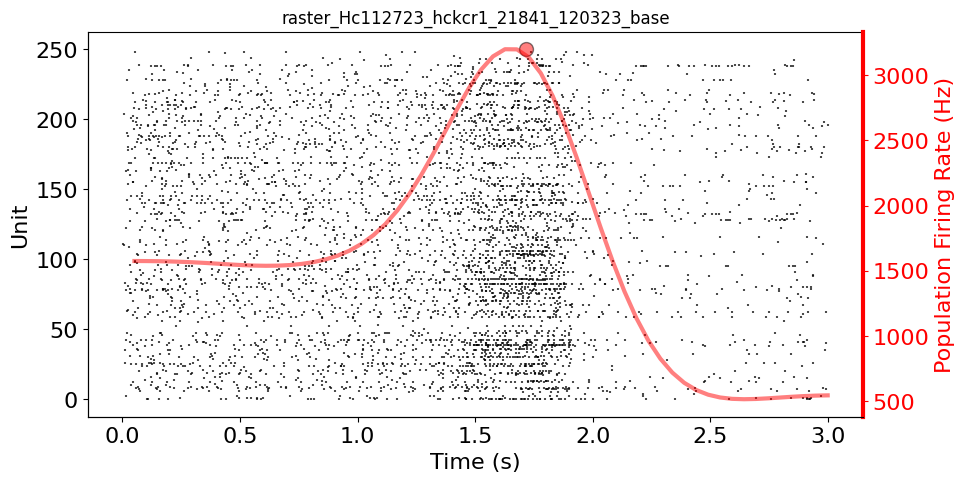

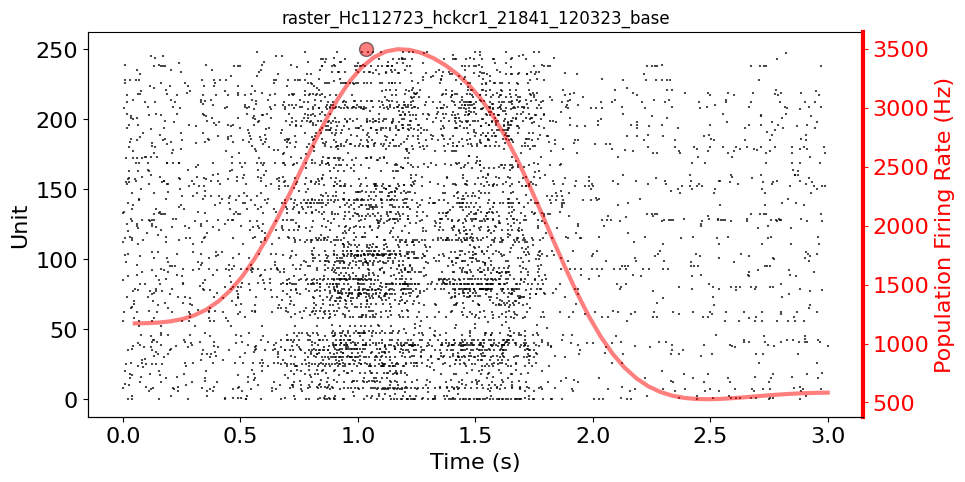

In [6]:
for i, bst in sd_burst.items():
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs = ephys.plot_raster_with_fr(train=bst["SpikeData"].train, title=figure_name, bin_size=0.05, axs=axs)
    # plot the peak point and 90% drop to the left and right
    t = pe.bins[pe.peak_indices][i]
    axs.plot(t-burst_range[i][0], 250, 'o', color='red', markersize=10, alpha=0.5 , markeredgecolor='k')
    # plt.savefig(f"figures/{figure_name}_burst_{i}.png")

In [ ]:
# spilt burst into 4 parts: find the peak,  

In [17]:
bst["binarized_train"].shape

(249, 60)

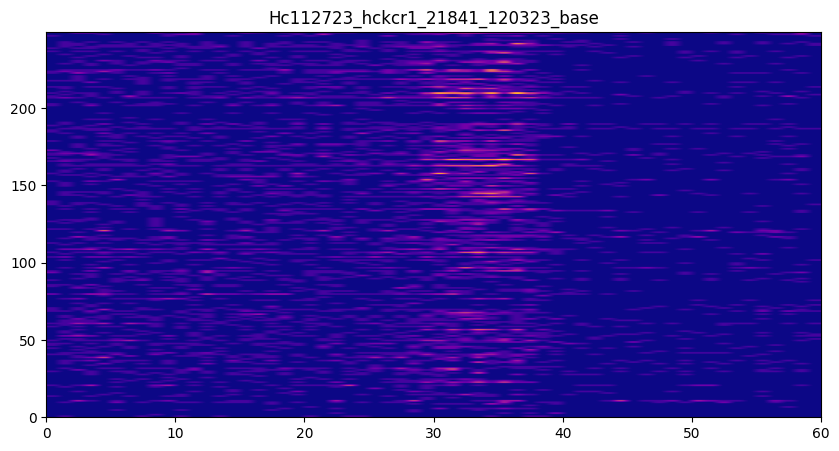

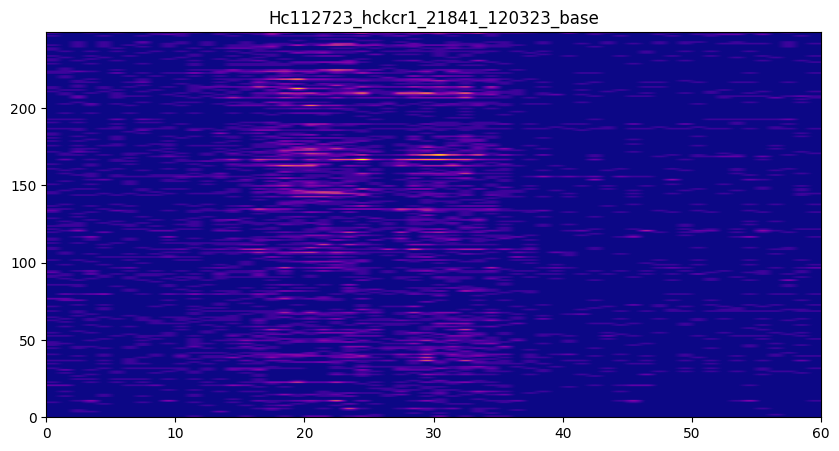

In [18]:
# plot the binned train
for b in [0, 1]: 
    bin_train = sd_burst[b]["binarized_train"] 
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.imshow(bin_train, aspect="auto", cmap="plasma", vmin=np.min(bin_train), vmax=np.max(bin_train), extent=[0, bin_train.shape[1], 0, bin_train.shape[0]])
    axs.set_title(figure_name)
    # axs.set_xlim(800, 1200)
    plt.savefig(f"figures/{figure_name}_bin_train_{b}.png")
    plt.show()

In [19]:
print(np.min(bin_train), np.max(bin_train), np.unique(bin_train))
print(np.max(sd_burst[1]["binarized_train"]), np.unique(sd_burst[1]["binarized_train"]))

0 11 [ 0  1  2  3  4  5  6  7  8  9 11]
11 [ 0  1  2  3  4  5  6  7  8  9 11]


In [23]:
import matplotlib.pyplot as plt
import imageio
# import matplotlib.animation as animation

# Enable interactive plots in Jupyter Notebook
# %matplotlib notebook
for b in [0, 1]: 
    bst = sd_burst[b]
    nd = bst["SpikeData"].neuron_data[0]
    coordinates = np.array([nd[i]["position"] for i in range(len(nd))])
    print(len(coordinates), coordinates[0])

    # List of firing rate lists for each coordinate
    firing_rates = bst["binarized_train"].T
    print(firing_rates.shape)
    print(firing_rates[0].shape)
    # find the min and max frng rate
    min_fr = 0
    max_fr = np.max(firing_rates)
    # from 0 to max_fr, create a discrete color map with arange(0, max_fr, 1)
    cmap = plt.get_cmap('Reds')
    colors = cmap(np.linspace(0, 1, max_fr+1))
    print(len(colors))
    # colors = ["white", "red", "orange", "blue", "green", "purple", "pink"]

    # clean the figure folder before creating new figures
    shutil.rmtree(f'figures/burst{b}', ignore_errors=True)
    os.makedirs(f'figures/burst{b}')

    # Create a scatter plot with the first firing rate value for each coordinate
    fig_id = 0
    alp=0.3
    for timespan in range(0, firing_rates.shape[0]):
        # for alp in np.arange(0.3, 0, -0.1):
        fig, axs = plt.subplots(2, 1, figsize=(16, 10), height_ratios=[3, 1])
        axs[0].scatter(coordinates[:, 0], coordinates[:, 1], s=100, c=[colors[i] for i in firing_rates[timespan]], alpha=alp)
        axs[0].set_title(f'Frame {timespan}')
        # plot the raster
        for i in range(len(bst["SpikeData"].train)):
            axs[1].scatter(bst["SpikeData"].train[i], [i]*len(bst["SpikeData"].train[i]), s=1, color='k', alpha=0.5)
        # draw a red line at the origin
        axs[1].axvline(x=timespan*bin_bin, color='r', linewidth=3)
        axs[1].set_xlabel('Time (s)', fontsize=12)
        axs[1].set_ylabel('Units', fontsize=12)
        plt.savefig(f'figures/burst{b}/burst{b}_{fig_id}.png')
        plt.close()
        fig_id += 1
    # plt.show()

    images = []
    burst_figures = os.listdir(f'figures/burst{b}')
    sorted_images = ['burst']*len(burst_figures)
    for filename in burst_figures:
        sorted_images[int(filename.split('_')[-1].split('.')[0])] = filename
    # # Load images and apply fade-in and fade-out effects
    # for filename in sorted_images:
    #     img = imageio.imread(f'figures/burst{b}/{filename}')
    #     height, width, _ = img.shape
    #     frames = []
    #     # Fade out
    #     for alpha in np.linspace(1, 0, 10):
    #         img_with_alpha = np.dstack([img, np.ones((height, width), dtype=img.dtype) * int(255 * alpha)])
    #         frames.append(img_with_alpha)
    #     images.extend(frames)
    # # show the first image
    # plt.imshow(images[0])
    # # Save GIF
    # imageio.mimsave(f'figures/burst{b}.gif', images, duration=0.05)

    for filename in sorted_images:
        # make each frame fade in and fade out 
        images.append(imageio.imread(f'figures/burst{b}/{filename}'))
    imageio.mimsave(f'figures/burst{b}.gif', images, duration=0.4)

/tmp/ipykernel_53732/2737516665.py:9: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  nd = bst["SpikeData"].neuron_data[0]


249 [1242.5 1312.5]
(60, 249)
(249,)
10


/tmp/ipykernel_53732/2737516665.py:70: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'figures/burst{b}/{filename}'))


249 [1242.5 1312.5]
(60, 249)
(249,)
12


# Example & Testing 

In [22]:
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation, PillowWriter
# import numpy as np

# x1 = np.arange(0, -0.2, -0.002)
# y1 = np.arange(0, -0.2, -0.002)
# x2 = np.arange(3.9, 3.7, -0.002)
# y2 = np.arange(0, 1, 0.01)
# x3 = np.arange(0, 1.8, 0.018)
# y3 = np.array(x3**2)

# fig,ax = plt.subplots()

# def animate(i):
#     ax.clear()
#     ax.set_xlim(-4,4)
#     ax.set_ylim(-4,4)
#     line, = ax.plot(x1[0:i], y1[0:i], color = 'blue', lw=1)
#     line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
#     line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
#     point1, = ax.plot(x1[i], y1[i], marker='.', color='blue')
#     point2, = ax.plot(x2[i], y2[i], marker='.', color='red')
#     point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
#     return line, line2, line3, point1, point2, point3,
        
# ani = FuncAnimation(fig, animate, interval=40, blit=True, repeat=True, frames=100)    
# ani.save("TLI.gif", dpi=300, writer=PillowWriter(fps=25))


/tmp/ipykernel_1611215/425242751.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Reds')


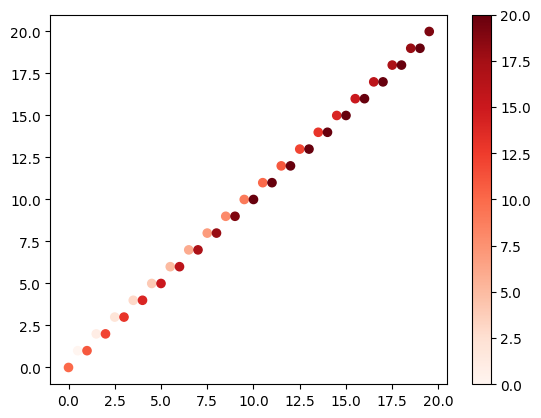

In [98]:
import matplotlib.pyplot as plt
cm = plt.cm.get_cmap('Reds')
xy = np.arange(20)
z = np.arange(10, 30)
sc0 = plt.scatter(xy+0.5, xy+1, c=xy, vmin=0, vmax=20, s=35, cmap=cm)
sc = plt.scatter(xy, xy, c=z, vmin=0, vmax=20, s=35, cmap=cm)  # color is fixed by z value
plt.colorbar(sc)
plt.show()